Download the “Monatszahlen Verkehrsunfälle” Dataset from the München Open Data Portal. Here you see the number of accidents for specific categories per month. Important are the first 5 columns:

1. Category
2. Accident-type (insgesamt means total for all subcategories)
3. Year
4. Month
5. Value


Your goal would be to visualise historically the number of accidents per category (column1). 

The dataset currently contains values until the end of 2020. 

Create an application that forecasts the values for:

Category: 'Alkoholunfälle'

Type: 'insgesamt

Year: '2021'

Month: '01'

In [1]:
import matplotlib.pyplot as plt  # plots
import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulations
import seaborn as sns  # more plots
import datetime as dt

import warnings  # `do not disturbe` mode
from itertools import product  # some useful functions

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf  # statistics and econometrics
import statsmodels.tsa.api as smt
from dateutil.relativedelta import relativedelta  # working with dates with style
from scipy.optimize import minimize  # for function minimization
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle

warnings.filterwarnings("ignore")

# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

In [2]:
# sns.set()


In [3]:
pd.options.display.max_rows = 500

In [4]:
df = pd.read_csv('dataset1.csv')

In [5]:
df.rename(columns={'MONATSZAHL': 'Category', 'AUSPRAEGUNG': 'Accident_Type', 'JAHR':'YEAR', 'MONAT':'MONTH',
                   'WERT':'VALUE'}, inplace=True)
df=df[['Category','Accident_Type','YEAR','MONTH','VALUE']]


In [6]:
df.shape

(1995, 5)

In [7]:
df.Category.unique()

array(['Alkoholunfälle', 'Fluchtunfälle', 'Verkehrsunfälle'], dtype=object)

In [8]:
df.Accident_Type.unique()

array(['insgesamt', 'Verletzte und Getötete', 'mit Personenschäden'],
      dtype=object)

In [9]:
df_1 = df[(df.Category=='Alkoholunfälle')&(df.Accident_Type=='insgesamt')&(df.MONTH != 'Summe')].copy()
df_1.shape

(264, 5)

In [10]:
df_1.head()

,Category,Accident_Type,YEAR,MONTH,VALUE
0,Alkoholunfälle,insgesamt,2021,202101,NaN
1,Alkoholunfälle,insgesamt,2021,202102,NaN
2,Alkoholunfälle,insgesamt,2021,202103,NaN
3,Alkoholunfälle,insgesamt,2021,202104,NaN
4,Alkoholunfälle,insgesamt,2021,202105,NaN


In [11]:
df_1.tail()

,Category,Accident_Type,YEAR,MONTH,VALUE
280,Alkoholunfälle,insgesamt,2000,200008,77.0
281,Alkoholunfälle,insgesamt,2000,200009,84.0
282,Alkoholunfälle,insgesamt,2000,200010,83.0
283,Alkoholunfälle,insgesamt,2000,200011,71.0
284,Alkoholunfälle,insgesamt,2000,200012,85.0


In [12]:

df_1["MONTH"] = pd.to_numeric(df_1["MONTH"])
df_1['DT'] = pd.to_datetime(df_1["MONTH"], format='%Y%m')
df_1 = df_1.sort_values('DT')

In [13]:
df_1.tail()

,Category,Accident_Type,YEAR,MONTH,VALUE,DT
7,Alkoholunfälle,insgesamt,2021,202108,NaN,2021-08-01
8,Alkoholunfälle,insgesamt,2021,202109,NaN,2021-09-01
9,Alkoholunfälle,insgesamt,2021,202110,NaN,2021-10-01
10,Alkoholunfälle,insgesamt,2021,202111,NaN,2021-11-01
11,Alkoholunfälle,insgesamt,2021,202112,NaN,2021-12-01


In [14]:
sdate = dt.date(df_1.DT.min().year,df_1.DT.min().month,df_1.DT.min().day) 
edate = dt.date(df_1.DT.max().year,df_1.DT.max().month,df_1.DT.max().day) + pd.DateOffset(months=1)

In [15]:
sdate

datetime.date(2000, 1, 1)

In [16]:
edate

Timestamp('2022-01-01 00:00:00')

In [17]:
pd.date_range(sdate, edate, freq='m')

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30',
               '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31',
               '2021-11-30', '2021-12-31'],
              dtype='datetime64[ns]', length=264, freq='M')

In [18]:
df_1['DT'] = pd.date_range(sdate, edate, freq='m')

In [19]:
df_1.set_index('DT', inplace=True)

<AxesSubplot:xlabel='DT'>

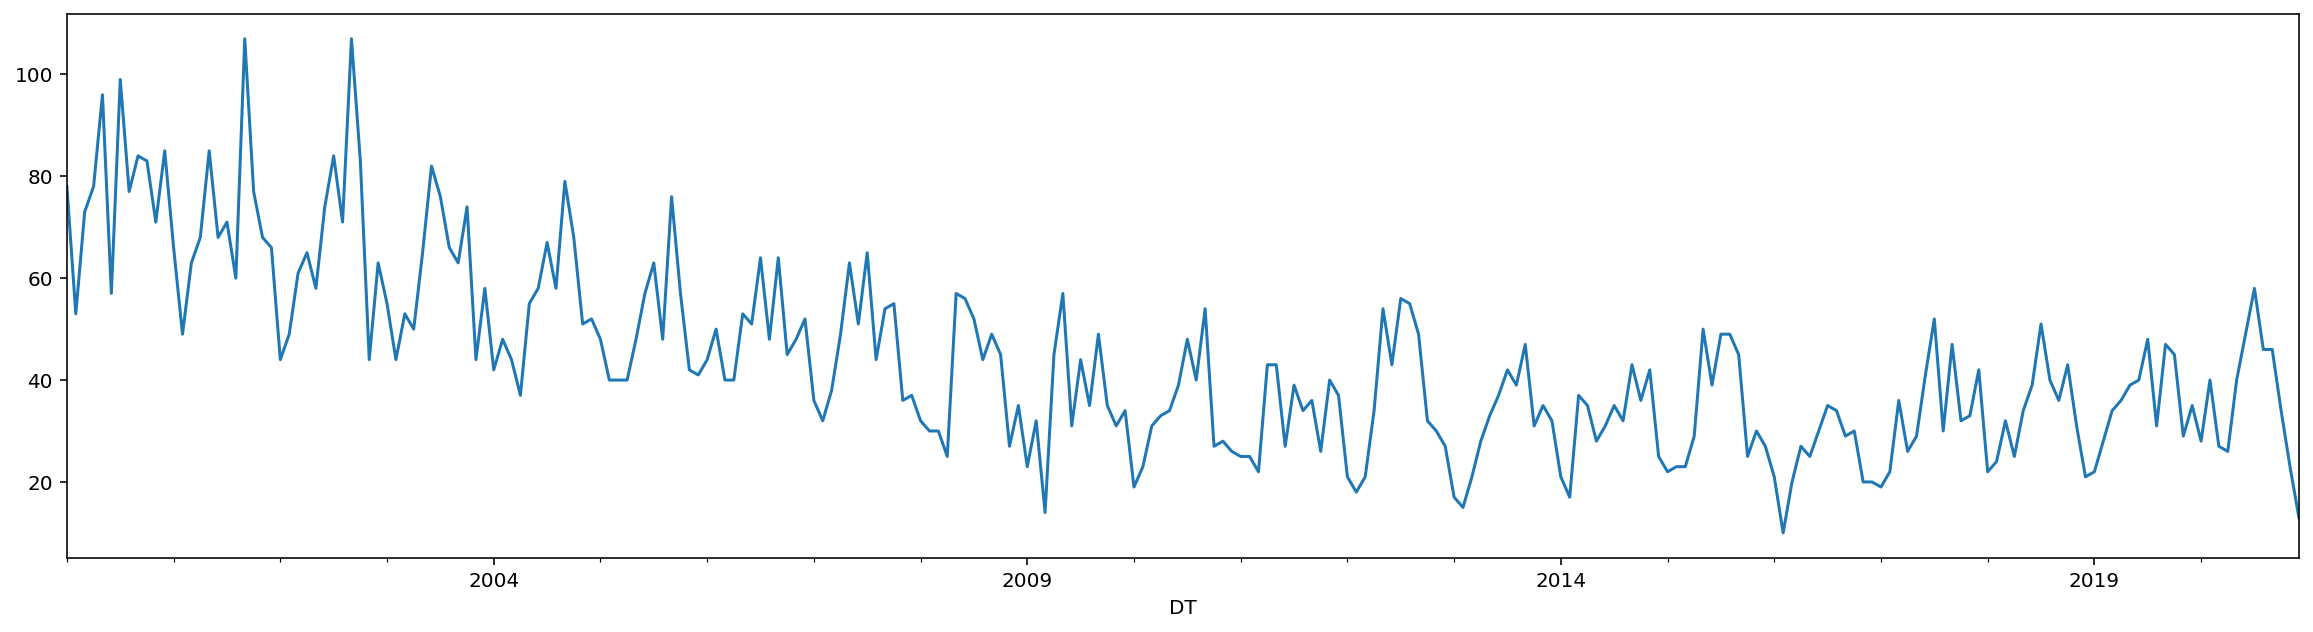

In [20]:
accident_values = df_1[(df_1.MONTH <= 202012)].VALUE

accident_values.plot(figsize=(20,5))

In [21]:
# p = plt.plot(accident_values.index,accident_values.values)

In [22]:
def tsplot(y, lags=None, figsize=(12, 7), style="bmh"):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)   # Plot the accident values
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(
            "Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}".format(p_value)
        )
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax) # Plot the autocorrelation
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax) # Plot the partial autocorrelation
        plt.tight_layout()

In [23]:
df_1[(df_1.MONTH <= 202012)].VALUE

DT
2000-01-31     78.0
2000-02-29     53.0
2000-03-31     73.0
2000-04-30     78.0
2000-05-31     96.0
2000-06-30     57.0
2000-07-31     99.0
2000-08-31     77.0
2000-09-30     84.0
2000-10-31     83.0
2000-11-30     71.0
2000-12-31     85.0
2001-01-31     66.0
2001-02-28     49.0
2001-03-31     63.0
2001-04-30     68.0
2001-05-31     85.0
2001-06-30     68.0
2001-07-31     71.0
2001-08-31     60.0
2001-09-30    107.0
2001-10-31     77.0
2001-11-30     68.0
2001-12-31     66.0
2002-01-31     44.0
2002-02-28     49.0
2002-03-31     61.0
2002-04-30     65.0
2002-05-31     58.0
2002-06-30     74.0
2002-07-31     84.0
2002-08-31     71.0
2002-09-30    107.0
2002-10-31     83.0
2002-11-30     44.0
2002-12-31     63.0
2003-01-31     55.0
2003-02-28     44.0
2003-03-31     53.0
2003-04-30     50.0
2003-05-31     65.0
2003-06-30     82.0
2003-07-31     76.0
2003-08-31     66.0
2003-09-30     63.0
2003-10-31     74.0
2003-11-30     44.0
2003-12-31     58.0
2004-01-31     42.0
2004-02-29     48

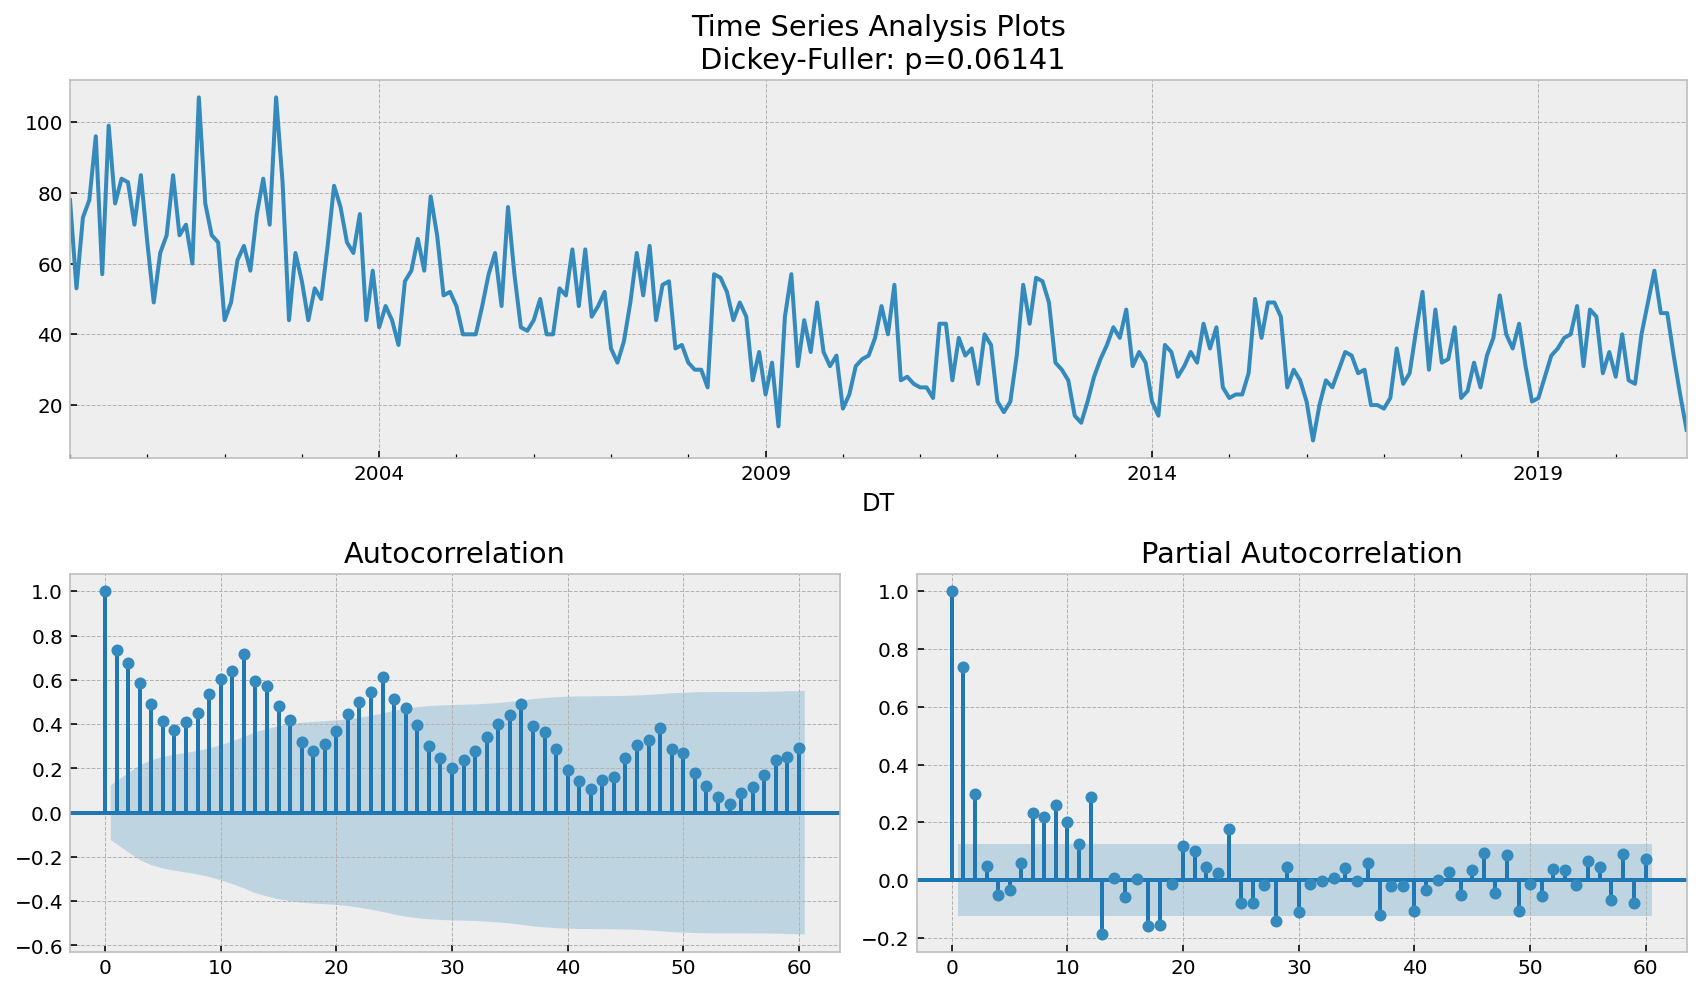

In [24]:
tsplot(df_1[(df_1.MONTH <= 202012)].VALUE, lags=60)

In [25]:
# Importing everything from above

from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [26]:
ads_diff = df_1[(df_1.MONTH <= 202012)].VALUE - df_1[(df_1.MONTH <= 202012)].VALUE.shift(6)

ads_diff.head(10)


DT
2000-01-31     NaN
2000-02-29     NaN
2000-03-31     NaN
2000-04-30     NaN
2000-05-31     NaN
2000-06-30     NaN
2000-07-31    21.0
2000-08-31    24.0
2000-09-30    11.0
2000-10-31     5.0
Name: VALUE, dtype: float64

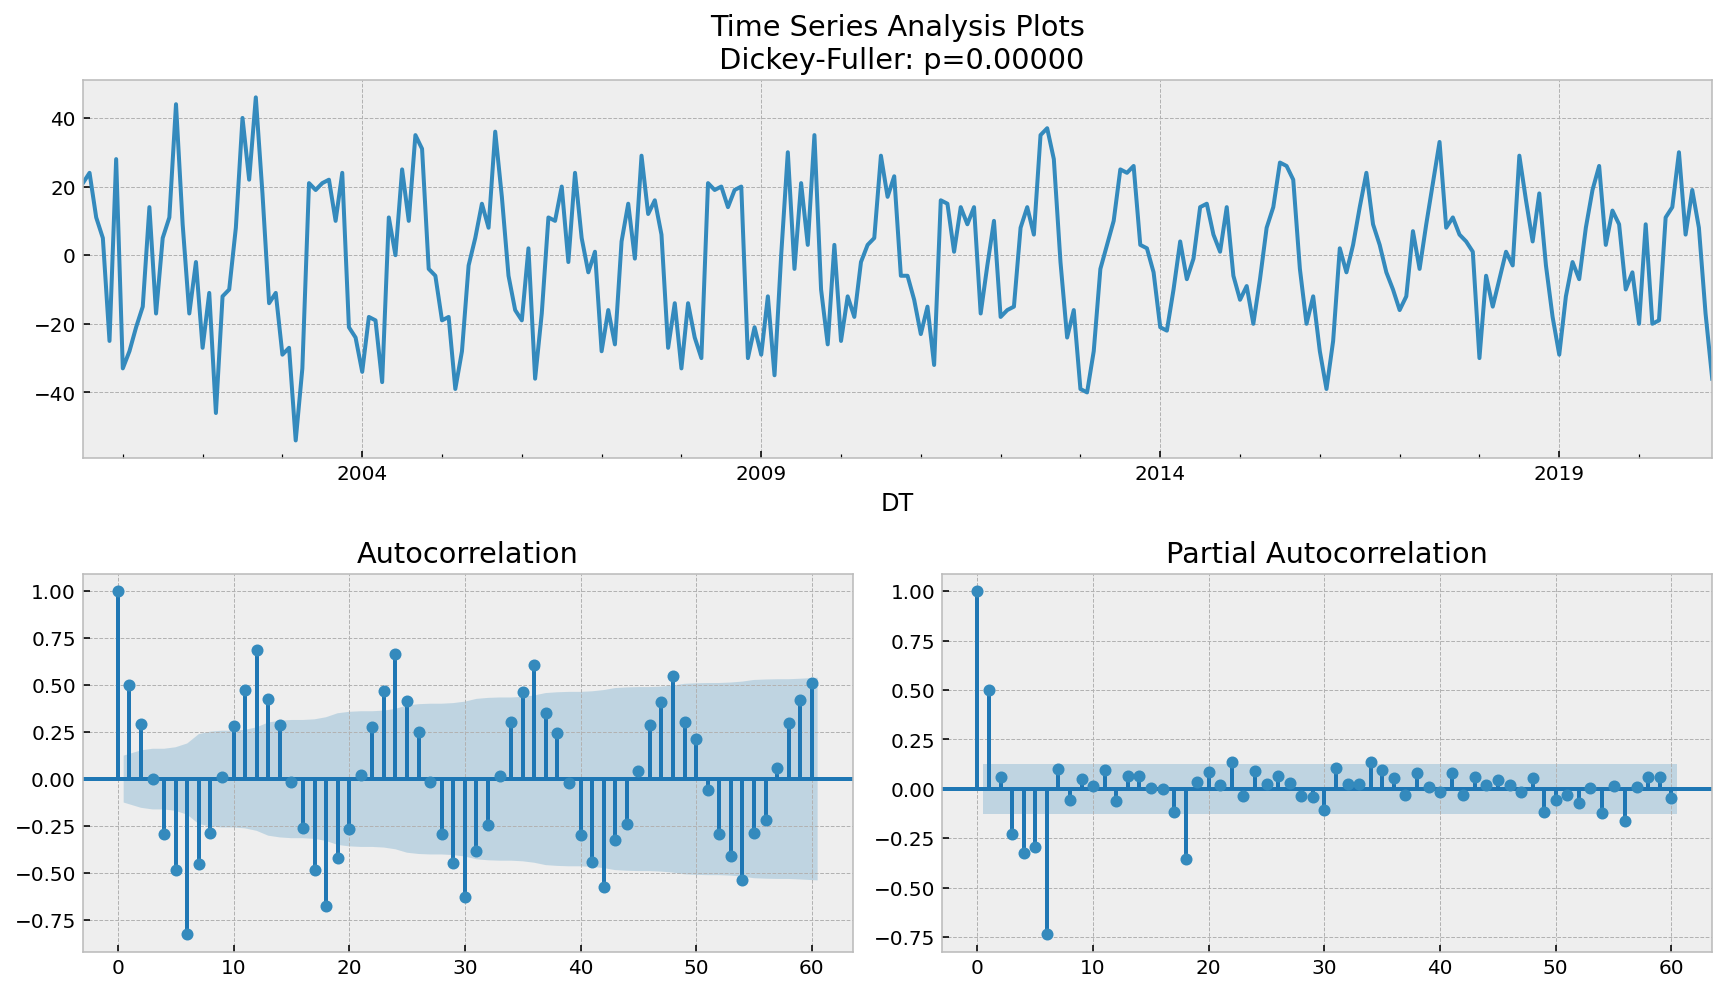

In [27]:
tsplot(ads_diff[6:], lags=60)

In [28]:
# setting initial values and some bounds for them
ps = range(2, 5)
d = 1
qs = range(2, 5)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)
s = 12 

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [29]:
parameters_list

[(2, 2, 0, 0),
 (2, 2, 0, 1),
 (2, 2, 1, 0),
 (2, 2, 1, 1),
 (2, 3, 0, 0),
 (2, 3, 0, 1),
 (2, 3, 1, 0),
 (2, 3, 1, 1),
 (2, 4, 0, 0),
 (2, 4, 0, 1),
 (2, 4, 1, 0),
 (2, 4, 1, 1),
 (3, 2, 0, 0),
 (3, 2, 0, 1),
 (3, 2, 1, 0),
 (3, 2, 1, 1),
 (3, 3, 0, 0),
 (3, 3, 0, 1),
 (3, 3, 1, 0),
 (3, 3, 1, 1),
 (3, 4, 0, 0),
 (3, 4, 0, 1),
 (3, 4, 1, 0),
 (3, 4, 1, 1),
 (4, 2, 0, 0),
 (4, 2, 0, 1),
 (4, 2, 1, 0),
 (4, 2, 1, 1),
 (4, 3, 0, 0),
 (4, 3, 0, 1),
 (4, 3, 1, 0),
 (4, 3, 1, 1),
 (4, 4, 0, 0),
 (4, 4, 0, 1),
 (4, 4, 1, 0),
 (4, 4, 1, 1)]

In [30]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = SARIMAX(
                df_1[(df_1.MONTH <= 202012)].VALUE,
                order=(param[0], d, param[1]),
                seasonal_order=(param[2], D, param[3], s),
            ).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ["parameters", "aic"]
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by="aic", ascending=True).reset_index(drop=True)

    return result_table

In [31]:
TRAIN=False

In [32]:
# %%time
model_filename="SARIMA_best_model.pkl"

if TRAIN==True:
    result_table = optimizeSARIMA(parameters_list, d, D, s)
    result_table.head()
    p, q, P, Q = result_table.parameters[0]

    # set the parameters that give the lowest AIC

    best_model = sm.tsa.statespace.SARIMAX(df_1[(df_1.MONTH <= 202012)].VALUE, 
                                           order=(p, d, q), 
                                           seasonal_order=(P, D, Q, s)).fit(disp=-1)
    print(best_model.summary())
    pickle.dump(best_model, open(model_filename, 'wb'))
    
    
else:
    best_model = pickle.load(open(model_filename, 'rb'))

CPU times: user 13.9 ms, sys: 11.6 ms, total: 25.5 ms
Wall time: 24 ms


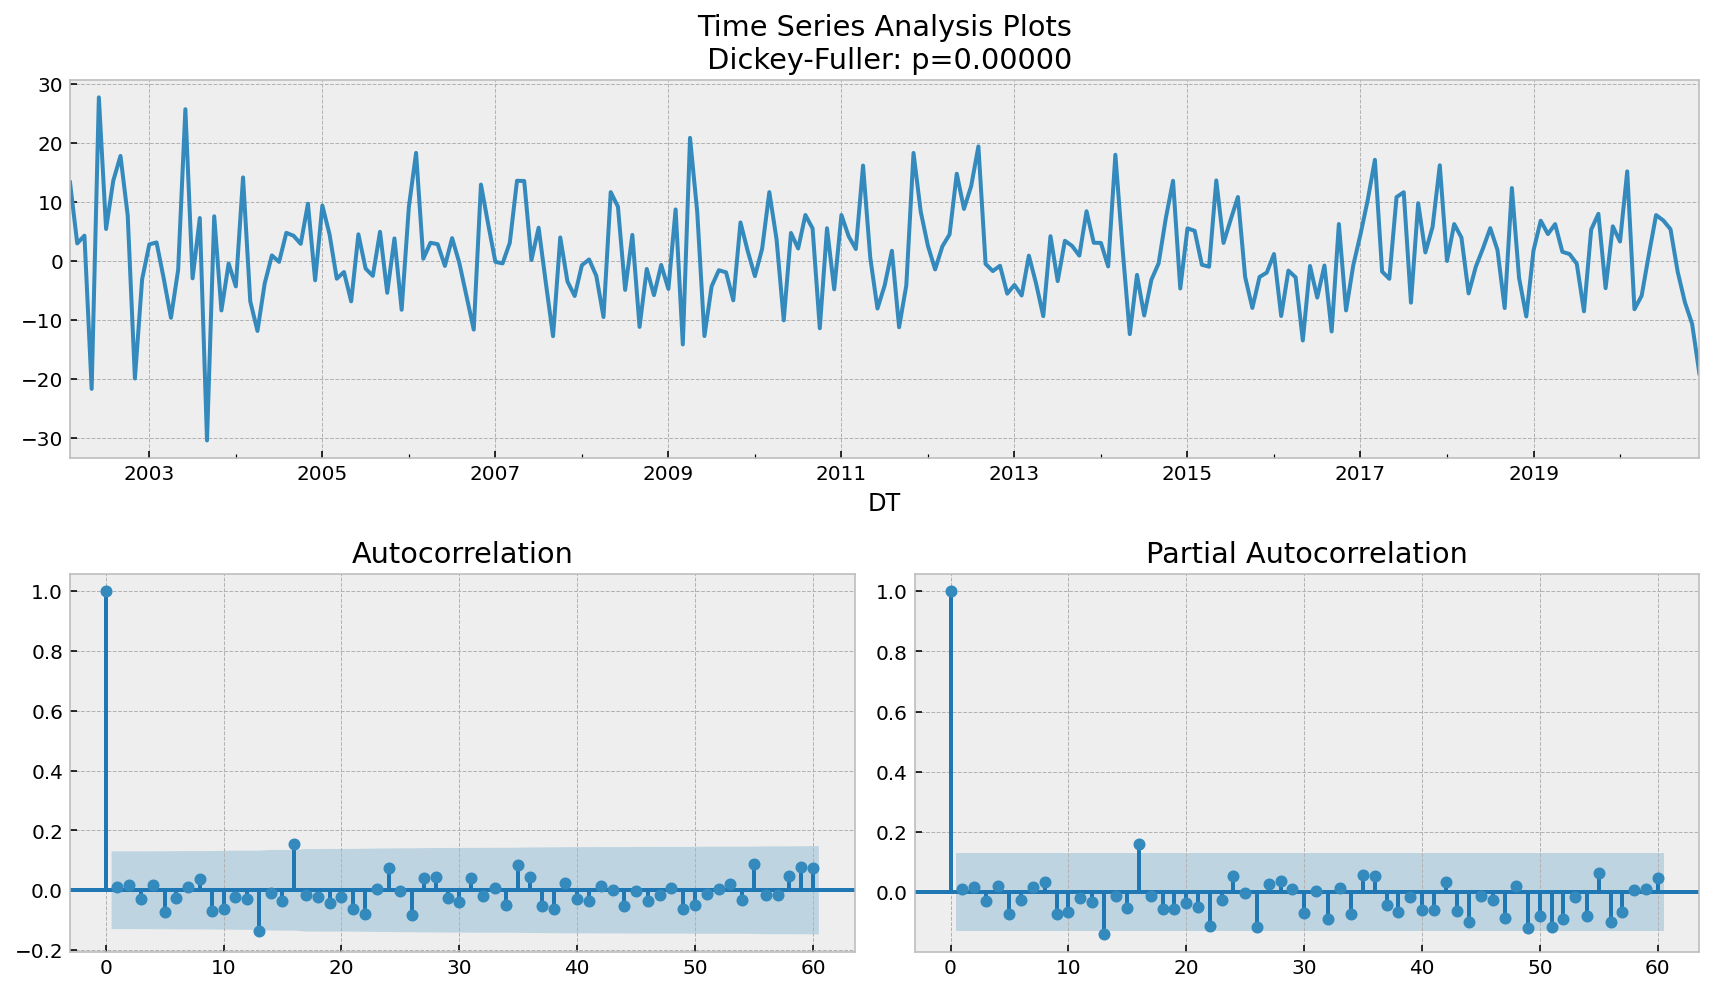

In [33]:
tsplot(best_model.resid[24 + 1 :], lags=60)

In [72]:
def plot_forecast(series, model, n_steps):
    """
        Plots model vs predicted values
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ["actual"]
    data["sarima_model"] = model.fittedvalues
    
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data["sarima_model"][: s + 1] = np.NaN

    # forecasting on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.sarima_model.append(forecast)
    
    forecast.index = pd.date_range(data.index.min(), data.index.max() + pd.DateOffset(months=n_steps+1), freq='m')
    
    plt.figure(figsize=(20, 8))
    plt.plot(forecast, color="r", label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color="lightgrey")
    plt.plot(data.actual, label="actual")
    plt.xlabel('YEAR')
    plt.ylabel('Number of Accidents')
    plt.title('Actual vs Forecasted :  Alkoholunfalle and insgesamt case')
    plt.legend()
    plt.grid(False)
    plt.savefig('images/alkoholunfalle_insgesamt_predicted.jpg')
    return (pd.DataFrame(forecast))

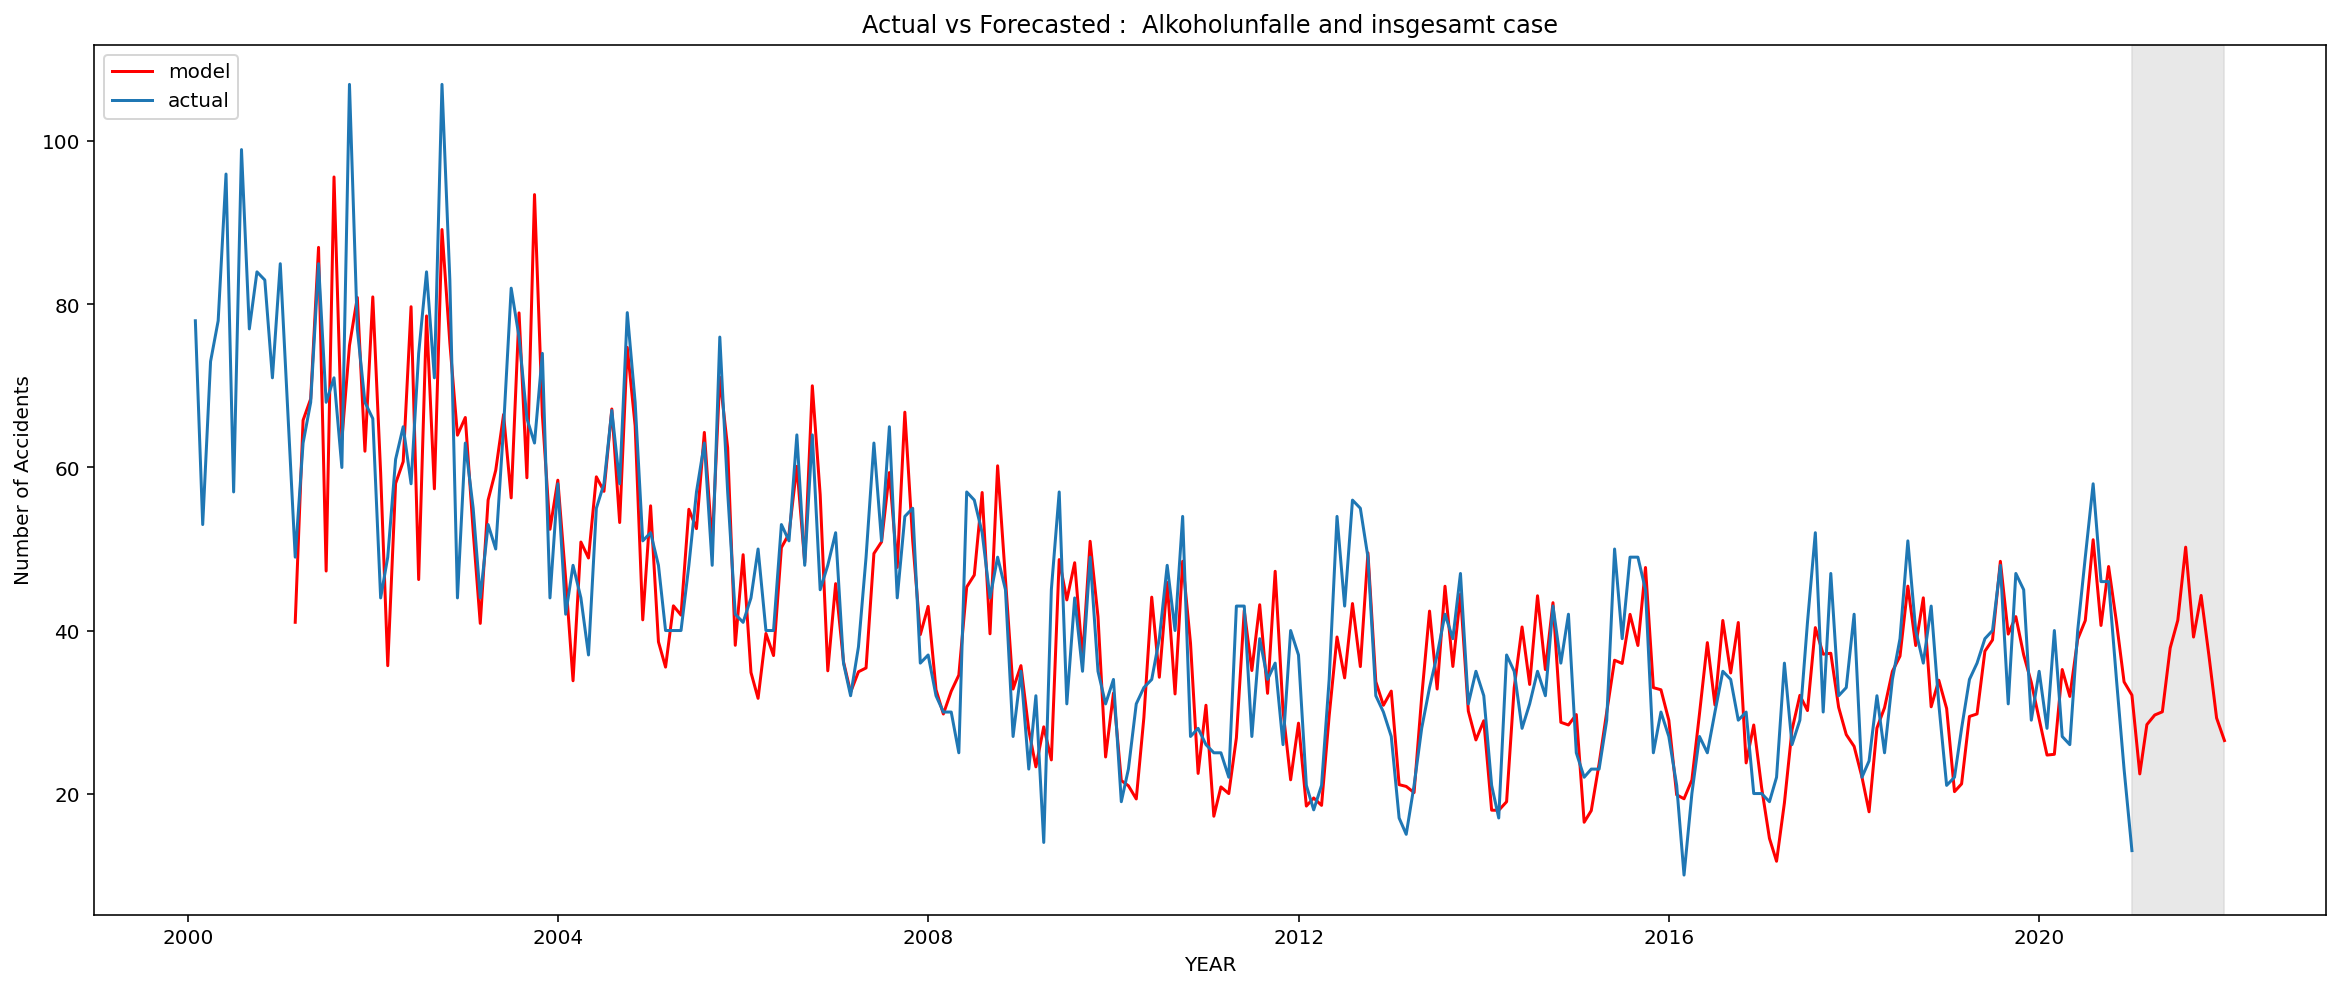

In [73]:
df_forecast = plot_forecast(df_1[(df_1.MONTH <= 202012)][['VALUE']], best_model, 11)[-12:]
df_forecast.columns=['pred_values']

In [36]:
df_forecast.tail()

,pred_values
2021-08-31,39.200257
2021-09-30,44.305633
2021-10-31,36.876260
2021-11-30,29.265131
2021-12-31,26.500800


In [37]:

df_forecast['year'] = df_forecast.index.year
df_forecast['month'] = df_forecast.index.month
df_forecast.reset_index(inplace=True)


In [38]:
year=2021
month=10
values = df_forecast[(df_forecast.year==year) & (df_forecast.month==month)]['pred_values'].values[0]
print(values)

36.87626004197102


In [39]:
## Make an API

In [59]:
from flask import Flask, jsonify, request

# creating a Flask app
app = Flask(__name__)



@app.route('/predict', methods = ['GET', 'POST']) 
def load_predict():
    print('load_predict function')
    if(request.method == 'POST'):
        print('reached inside if')
        print(request.get_data())

        data = json.loads(request.get_data())
        year = int(data.get("year","2021"))
        month= int(data.get("month","10"))
        print("year = ", year)
        print("month = ", month)
        values = df_forecast[(df_forecast.year==year) & (df_forecast.month==month)]['pred_values'].values[0]
        return json.dumps({'values':values})
    
    

# if __name__ == '__main__':
#     app.run(debug=False, port=5000, host='0.0.0.0')

In [41]:
# if __name__ == '__main__':
#     app.run(debug=False, port=5000, host='0.0.0.0')

Hello


<Response [500]>
